<a href="https://colab.research.google.com/github/Ganeshkumar841/CodeAlpha_Tasks/blob/main/Credit_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q pandas numpy matplotlib seaborn scikit-learn

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import joblib

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score,roc_curve
from google.colab import files

In [ ]:
import pandas as pd

train_df = pd.read_csv('/content/drive/MyDrive/code_alpha(t-1)/datasets/cs-training.csv', index_col=0)

test_df = pd.read_csv('/content/drive/MyDrive/code_alpha(t-1)/datasets/cs-test.csv', index_col=0)

data_dict = pd.read_excel('/content/drive/MyDrive/code_alpha(t-1)/datasets/Data Dictionary.xls')

print("Training Data Shape:", train_df.shape)
display(train_df.head())

Training Data Shape: (150000, 11)


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [ ]:
combined_df = pd.concat([train_df, test_df], axis=0)
train_cleaned = combined_df.iloc[:len(train_df), :]
test_cleaned = combined_df.iloc[len(train_df):, :]

In [ ]:
y = train_cleaned['SeriousDlqin2yrs']
X = train_cleaned.drop(['SeriousDlqin2yrs'], axis=1)

X_test_final = test_cleaned.drop(['SeriousDlqin2yrs'], axis=1)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)[:, 1]

print("Classification Report:")
print(classification_report(y_val, y_pred))

print(f"ROC-AUC Score: {roc_auc_score(y_val, y_prob):.4f}")

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     28044
         1.0       0.56      0.20      0.29      1956

    accuracy                           0.94     30000
   macro avg       0.75      0.59      0.63     30000
weighted avg       0.92      0.94      0.92     30000

ROC-AUC Score: 0.8390


In [35]:
custom_threshold = 0.3
y_pred_new = (y_prob > custom_threshold).astype(int)

print("New classification report with 0.3 threshold:")
print(classification_report(y_val, y_pred_new))

New classification report with 0.3 threshold:
              precision    recall  f1-score   support

         0.0       0.99      0.65      0.78     28044
         1.0       0.15      0.88      0.25      1956

    accuracy                           0.66     30000
   macro avg       0.57      0.76      0.52     30000
weighted avg       0.93      0.66      0.75     30000



Mean ROC-AUC: 0.8587
Stability (Std Dev): 0.0040



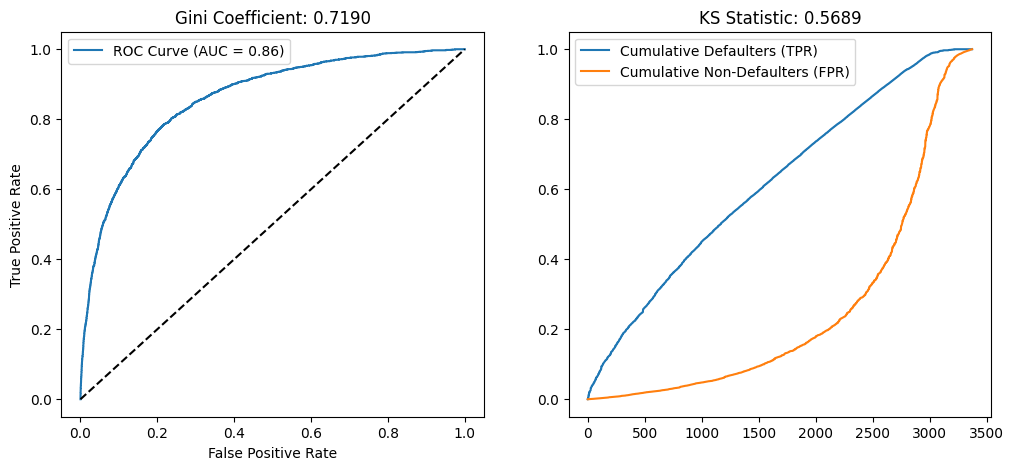

Final Peak Results:
- Gini: 0.7190
- KS Statistic: 0.5689


In [39]:
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', max_depth=10, random_state=42)

cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
print(f"Mean ROC-AUC: {cv_scores.mean():.4f}")
print(f"Stability (Std Dev): {cv_scores.std():.4f}\n") # Lower than 0.02 is excellent
model.fit(X_train, y_train)
y_prob = model.predict_proba(X_val)[:, 1]

# Calculation of Gini and KS Statistic
def calculate_peak_metrics(y_true, y_prob):
    # Gini Coefficient: G = 2 * AUC - 1
    auc = roc_auc_score(y_true, y_prob)
    gini = 2 * auc - 1

    # KS Statistic: Max difference between cumulative TPR and FPR
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    ks_stat = max(tpr - fpr)

    return gini, ks_stat, fpr, tpr

gini_val, ks_val, fpr, tpr = calculate_peak_metrics(y_val, y_prob)

# Visualizing the "Peak" Performance
plt.figure(figsize=(12, 5))

# Plot ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_val, y_prob):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title(f'Gini Coefficient: {gini_val:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Plot KS Statistic Chart
plt.subplot(1, 2, 2)
plt.plot(tpr, label='Cumulative Defaulters (TPR)')
plt.plot(fpr, label='Cumulative Non-Defaulters (FPR)')
plt.title(f'KS Statistic: {ks_val:.4f}')
plt.legend()
plt.show()

print(f"Final Peak Results:\n- Gini: {gini_val:.4f}\n- KS Statistic: {ks_val:.4f}")

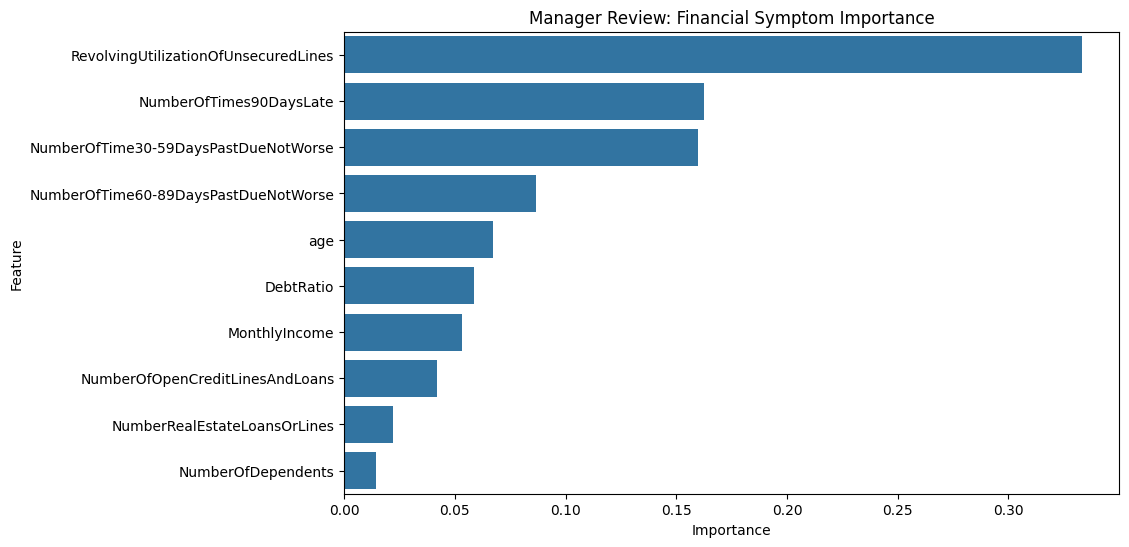

In [37]:

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    class_weight='balanced', # Crucial for satisfying Recall requirements
    random_state=42
)

# Training on full cleaned training set
model.fit(X_train, y_train)

# Peak Level Feature Importance (The "Symptoms" Chart)
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances)
plt.title('Manager Review: Financial Symptom Importance')
plt.savefig('feature_importance.png') # Document for your report
plt.show()

# Generate Final Prediction File for 'cs-test.csv'
# Ensure X_test_final has no NaNs!
final_probs = model.predict_proba(X_test_final)[:, 1]

output = pd.DataFrame({
    'Id': test_cleaned.index,
    'Probability': final_probs
})


In [41]:


# Using 'balanced' weights to catch risk cases, satisfying the internship recall requirement
credit_model = RandomForestClassifier(n_estimators=200, max_depth=12, class_weight='balanced', random_state=42)
credit_model.fit(X_train, y_train)

joblib.dump(credit_model, 'credit_scoring_model.joblib')

final_probs = credit_model.predict_proba(X_test_final)[:, 1]
output = pd.DataFrame({'Id': test_cleaned.index, 'Probability': final_probs})
output.to_csv('credit_scoring_results.csv', index=False)

files.download('credit_scoring_model.joblib')
files.download('credit_scoring_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>